In [1]:
import pennylane as qml
from pennylane import numpy as np
from embeddings_circuit import embedding_circuit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', font='serif')

In [2]:
CSWAP = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])

In [3]:
def featmap(x,weights,wires):
    return embedding_circuit(x,weights,wires)

In [4]:
n_layers = 10  # number of layers for featuremap, if applicable
n_inp = 1  # number of wires that feature map acts on
n_steps = 300  # steps of GD performed
log_step = 5  # how often the test error is calculated
batch_size = 2  # how many pairs are sampled in each training step
step_size = 0.01#0.05
n_all = 2*n_inp + 1

pennylane_dev = 'default.qubit'
optimizer = qml.RMSPropOptimizer(stepsize=step_size)
dev = qml.device(pennylane_dev, wires=n_all)   # Device to |<x|x'>|^2 using the SWAP trick.
dev2 = qml.device(pennylane_dev, wires=n_inp) # Device to compute <x| Pauli |x>. 

In [5]:
X = np.loadtxt("X_1d_sep.txt")  # load features
Y = np.loadtxt("Y_1d_sep.txt")  # load labels

In [6]:
init_pars = []
for i in range(n_layers):
    pars = [0.001 for j in range(n_inp)]
    init_pars.append(pars)

In [7]:
@qml.qnode(dev, cache=True)
def circuit(weights, x1=None, x2=None):

    # Load the two inputs into two different registers
    featmap(x1,weights, range(1, n_inp+1))
    featmap(x2,weights, range(n_inp+1, 2*n_inp+1))

    # Do a SWAP test
    qml.Hadamard(wires=0)
    for k in range(n_inp):
        qml.QubitUnitary(CSWAP, wires=[0, k+1, n_inp+k+1])
    qml.Hadamard(wires=0)

    # Measure overlap by checking ancilla
    return qml.expval(qml.PauliZ(0))

def tr_rr(weights, A=None):
    # Compute intra-class overlap A
    tr_rr = 0
    for a1 in A:
        for a2 in A:
            tr_rr += circuit(weights, x1=a1, x2=a2)
    tr_rr = tr_rr / len(A)**2
    return tr_rr

def tr_ss(weights, B=None):
    # Compute intra-class overlap B
    tr_ss = 0
    for b1 in B:
        for b2 in B:
            tr_ss += circuit(weights, x1=b1, x2=b2)
    tr_ss = tr_ss/len(B)**2
    return tr_ss

def tr_rs(weights, A=None, B=None):
    # Compute inter-class overlap A-B
    tr_rs = 0
    for a in A:
        for b in B:
            tr_rs += circuit(weights, x1=a, x2=b)
    tr_rs = tr_rs/(len(A)*len(B))
    return tr_rs

def cost(weights, A=None, B=None):

    # Fidelity cost,
    rr = tr_rr(weights, A=A)
    ss = tr_ss(weights, B=B)
    rs = tr_rs(weights, A=A, B=B)
    distance = - rs + 0.5 * (ss + rr)
    return 1 - distance  # min is 0

In [8]:
@qml.qnode(dev2, cache=True)
def bloch_function(weights, x1=None, component=None):
    
    featmap(x1,weights, range(0, n_inp))
    
    if component == 'Z':
        return qml.expval(qml.PauliZ(0))
    elif component == 'Y':
        return qml.expval(qml.PauliY(0))
    elif component == 'X':
        return qml.expval(qml.PauliX(0))

In [9]:
# Divide inputs into classes
A = X[Y == -1]
B = X[Y == 1]

In [10]:
pars = init_pars
print("Initial parameters ", init_pars)
cst = cost(pars, A=A, B=B)
print("Initial cost ", " -- ", cst)

Initial parameters  [[0.001], [0.001], [0.001], [0.001], [0.001], [0.001], [0.001], [0.001], [0.001], [0.001]]
Initial cost   --  0.9913185454196806


Text(0.5, 0, 'x')

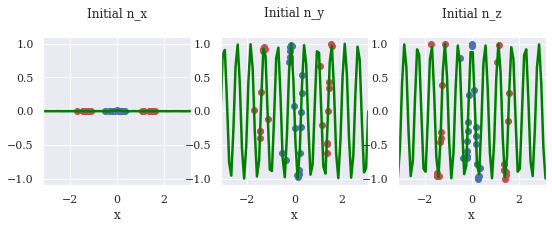

In [11]:
# Find initial n_x, n_y, n_z 
t = np.linspace(-np.pi, np.pi, 70)

# Computing n_x, n_y, and n_z for -pi < x < +pi.
init_nx = np.array([bloch_function(pars,x1=t_,component='X') for t_ in t])
init_ny = np.array([bloch_function(pars,x1=t_,component='Y') for t_ in t])
init_nz = np.array([bloch_function(pars,x1=t_,component='Z') for t_ in t])

# Computing n_x, n_y, and n_z for all x in A.
init_nx_A = np.array([bloch_function(pars,x1=t_,component='X') for t_ in A])
init_ny_A = np.array([bloch_function(pars,x1=t_,component='Y') for t_ in A])
init_nz_A = np.array([bloch_function(pars,x1=t_,component='Z') for t_ in A])

# Computing n_x, n_y, and n_z for all x in B.
init_nx_B = np.array([bloch_function(pars,x1=t_,component='X') for t_ in B])
init_ny_B = np.array([bloch_function(pars,x1=t_,component='Y') for t_ in B])
init_nz_B = np.array([bloch_function(pars,x1=t_,component='Z') for t_ in B])


# Start figure
fig = plt.figure(figsize=(9, 6))
# Plotting n_x
ax1 = fig.add_subplot(2, 3, 1)
ax1.set_title("Initial n_x", pad=20)
ax1.plot(t, init_nx,color='green', marker='', linestyle='-', linewidth=2.5)
ax1.scatter(A, init_nx_A, c='r')
ax1.scatter(B, init_nx_B, c='b')
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlim((-np.pi, np.pi))
ax1.set_xlabel("x")

# Plotting n_y
ax2 = fig.add_subplot(2, 3, 2)
ax2.set_title("Initial n_y", pad=20)
ax2.plot(t, init_ny,color='green', marker='', linestyle='-', linewidth=2.5)
ax2.scatter(A, init_ny_A, c='r')
ax2.scatter(B, init_ny_B, c='b')
ax2.set_ylim((-1.1, 1.1))
ax2.set_xlim((-np.pi, np.pi))
ax2.set_xlabel("x")

# Plotting n_z
ax3 = fig.add_subplot(2, 3, 3)
ax3.set_title("Initial n_z", pad=20)
ax3.plot(t, init_nz,color='green', marker='', linestyle='-', linewidth=2.5)
ax3.scatter(A, init_nz_A, c='r')
ax3.scatter(B, init_nz_B, c='b')
ax3.set_ylim((-1.1, 1.1))
ax3.set_xlim((-np.pi, np.pi))
ax3.set_xlabel("x")

In [12]:
# Optimizing the overlap or Hilbert-Schmidt cost function

for i in range(n_steps):
    
    # Sample a batch of pairs
    selectA = np.random.choice(range(len(A)), size=(batch_size,), replace=True)
    selectB = np.random.choice(range(len(B)), size=(batch_size,), replace=True)
    A_batch = [A[s] for s in selectA]
    B_batch = [B[s] for s in selectB]
    
    # Walk one optimization step (using all training samples)
    #pars = optimizer.step(lambda w: cost(w, A=A_batch, B=B_batch), pars)
    pars = optimizer.step(lambda w: tr_rs(w, A=A_batch, B=B_batch), pars)
    
    
print("Final parameters ", pars)
cst = cost(pars, A=A, B=B)
print("Final cost ", " -- ", cst)

Final parameters  [[0.775126002847787], [1.343432237819721], [0.3849611958373512], [-0.5505343228300066], [-0.40409979460001355], [-0.09254352571295636], [-0.23940166910792493], [0.06038116720052859], [0.20358291630045786], [0.06587859801153512]]
Final cost   --  0.04214598139514947


Text(0.5, 0, 'x')

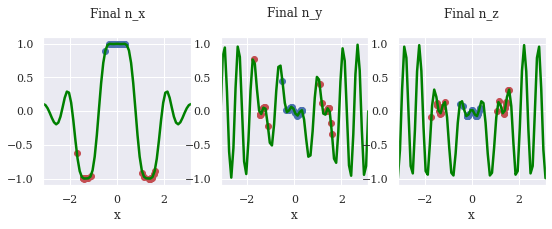

In [13]:
# Find final n_x, n_y, n_z
t = np.linspace(-np.pi, np.pi, 70)

# Computing n_x, n_y, and n_z for -pi < x < +pi.
final_nx = np.array([bloch_function(pars,x1=t_,component='X') for t_ in t])
final_ny = np.array([bloch_function(pars,x1=t_,component='Y') for t_ in t])
final_nz = np.array([bloch_function(pars,x1=t_,component='Z') for t_ in t])

# Computing n_x, n_y, and n_z for all x in A.
final_nx_A = np.array([bloch_function(pars,x1=t_,component='X') for t_ in A])
final_ny_A = np.array([bloch_function(pars,x1=t_,component='Y') for t_ in A])
final_nz_A = np.array([bloch_function(pars,x1=t_,component='Z') for t_ in A])

# Computing n_x, n_y, and n_z for all x in B.
final_nx_B = np.array([bloch_function(pars,x1=t_,component='X') for t_ in B])
final_ny_B = np.array([bloch_function(pars,x1=t_,component='Y') for t_ in B])
final_nz_B = np.array([bloch_function(pars,x1=t_,component='Z') for t_ in B])


# Start figure
fig = plt.figure(figsize=(9, 6))
# Plotting n_x
ax1 = fig.add_subplot(2, 3, 1)
ax1.set_title("Final n_x", pad=20)
ax1.plot(t, final_nx,color='green', marker='', linestyle='-', linewidth=2.5)
ax1.scatter(A, final_nx_A, c='r')
ax1.scatter(B, final_nx_B, c='b')
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlim((-np.pi, np.pi))
ax1.set_xlabel("x")

# Plotting n_y
ax2 = fig.add_subplot(2, 3, 2)
ax2.set_title("Final n_y", pad=20)
ax2.plot(t, final_ny,color='green', marker='', linestyle='-', linewidth=2.5)
ax2.scatter(A, final_ny_A, c='r')
ax2.scatter(B, final_ny_B, c='b')
ax2.set_ylim((-1.1, 1.1))
ax2.set_xlim((-np.pi, np.pi))
ax2.set_xlabel("x")

# Plotting n_z
ax3 = fig.add_subplot(2, 3, 3)
ax3.set_title("Final n_z", pad=20)
ax3.plot(t, final_nz,color='green', marker='', linestyle='-', linewidth=2.5)
ax3.scatter(A, final_nz_A, c='r')
ax3.scatter(B, final_nz_B, c='b')
ax3.set_ylim((-1.1, 1.1))
ax3.set_xlim((-np.pi, np.pi))
ax3.set_xlabel("x")